# Comparison between the mass-conservation constraint and the SHK geodesic

In [Lachos & Mielke (2018)](https://arxiv.org/pdf/1712.01888), it has been proved that the Wasserstein-Fisher-Rao distance can be seen as a cone of the space of probability measures with so-called the **spherical Hellinger-Kantrovich (SHK) distance**. 

We have seen (at least formally) that the SHK space is actually equivalent to the WFR space with the constraint that the total mass is always $1$. Moreover, Lachos & Mielke provides a formula to calculate a geodesic on the SHK space from a geodesic on the unconstrained WFR space. 

In this notebook, we will compare the projected geodesic and the geodesic calculated by our constrained algorithm.


In [1]:
# Import relevant libraries

import math
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic
import ipywidgets as widgets
from ipywidgets import interact

# The theory

## Conversion of the distance WFR -> SHK
We will consider the WFR distance with $\delta=1$:
$\begin{equation}\textrm{WFR}(\rho_0,\rho_1)^2 = \textrm{inf}\left\{\int_{0}^{1}\int_{\Omega} \frac{\|\omega\|^2 +\zeta^2}{2\rho}dxdt\middle|\partial_t \rho + \nabla\cdot \omega = \zeta, \rho(0)=\rho_0, \rho(1)=\rho_1\right\}\end{equation}$

The Hellinger-Kantrovich distance (Liero et al. 2015) has a slightly different definition, and the above expression is equal to $\frac{1}{2}\textrm{HK}_{1,1}(\rho_0,\rho_1)^2$. That is, we have 

$\begin{equation} \textrm{HK}_{1,1}(\rho_0,\rho_1) = \sqrt{2}\textrm{WFR}(\rho_0,\rho_1)\end{equation}$

Substituting this to the equation from Lachos & Mielke that connects HK & SHK, we have

$\begin{equation} \textrm{SHK}(\nu_0, \nu_1) = \textrm{arccos}\left(1 - \frac{\textrm{WFR}^2(\nu_0,\nu_1)}{4}\right)\end{equation}$

The following code implements this conversion.

In [2]:
def WFR_to_SHK(WFR):
    """ Convert WFR to SHK
    WFR: float, WFR value
    return: float, SHK value"""
    return math.acos(1-WFR**2/4)

## Conversion of a geodesic WFR -> SHK
Lachos & Mielke proved that, given a geodesic in the WFR space, we can project it to the SHK to obtain a geodeseic there. if $\rho$ is a geodesic in the WFR space between $\rho_0,\rho_1$, Theorem 2.7 from Lachos & Mielke shows that $\rho(\beta(t))/r(t)$ is a geodesic between $\bar{\rho}_0=\rho_0/r_0$ and $\bar{\rho}_1 = \rho_1/r_1, r_0=\rho_0(\Omega),r_1=\rho_1(\Omega)$ where

$\begin{align} \beta(t) &= \frac{r_0 \sin \left( t \textrm{SHK} (\bar{\rho}_0, \bar{\rho}_1) \right)}{r_1 \sin \left( (1-t) \textrm{SHK} (\bar{\rho}_0, \bar{\rho}_1) \right) + r_0 \sin \left( t \textrm{SHK} (\bar{\rho}_0, \bar{\rho}_1)\right)} \\ r(t) &=  
\frac{r_0 r_1 \sin \left( \textrm{SHK} (\bar{\rho}_0, \bar{\rho}_1) \right)}
{r_1 \sin \left( (1-t) \textrm{SHK} (\bar{\rho}_0, \bar{\rho}_1) \right) + r_0 \sin \left( t \textrm{SHK} (\bar{\rho}_0, \bar{\rho}_1) \right)}. \end{align}$


The following implements $\beta$ & $r$.

In [3]:
def beta(t, SHK, r0, r1):
    """
    Computes the value of β(t) based on the formula.

    Parameters:
    - t (float or np.ndarray): Parameter(s) between 0 and 1.
    - SHK (float): The SHK value.
    - r0 (float): Radius parameter r0.
    - r1 (float): Radius parameter r1.

    Returns:
    - float or np.ndarray: The computed value(s) of β(t).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    numerator = r0 * np.sin(t * SHK)
    denominator = r1 * np.sin((1 - t) * SHK) + r0 * np.sin(t * SHK)
    
    # Check for zero denominators
    if np.any(denominator == 0):
        raise ValueError("Denominator in beta(t) calculation is zero for at least one element in t.")
    
    return numerator / denominator

def r(t, SHK, r0, r1):
    """
    Computes the value of r(t) based on the formula.

    Parameters:
    - t (float or np.ndarray): Parameter(s) between 0 and 1.
    - SHK (float): The SHK value.
    - r0 (float): Radius parameter r0.
    - r1 (float): Radius parameter r1.

    Returns:
    - float or np.ndarray: The computed value(s) of r(t).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    numerator = r0 * r1 * np.sin(SHK)
    denominator = r1 * np.sin((1 - t) * SHK) + r0 * np.sin(t * SHK)
    
    # Check for zero denominators
    if np.any(denominator == 0):
        raise ValueError("Denominator in r(t) calculation is zero for at least one element in t.")
    
    return numerator / denominator

Now, suppose we calculated an unconstrained geodesic $\rho$, and we want to project it to the SHK space. The biggest challange is to find the reparametrization $\rho(\beta(t))$ since $\beta(t)$ is most likely not on our discretized grid. To find the values at such $t$, we simply consider a linear interpolation.

For more accurate interpolation, we can solve the constrained WFR problem such that $\rho_t(\Omega) = r(t)$, but we will not take this approach as the objective here is to compare the constrained WFR algorithm with the theoretical result.

In [4]:
def reparametrize_mass_distributions(mass_distributions, SHK, r0, r1, cs, ll):
    """
    Reparametrize the mass distributions according to the beta(t) function.

    Parameters:
    - mass_distributions (np.ndarray): Array of shape (time_dim, *space_dims)
    - SHK (float): SHK parameter for beta(t)
    - r0 (float): r0 parameter for beta(t)
    - r1 (float): r1 parameter for beta(t)
    - cs (tuple): the size of the spatial grid
    - ll (tuple): the length of the spatial domain

    Returns:
    - np.ndarray: Reparametrized mass distributions of the same shape.
    """
    time_dim = mass_distributions.shape[0]
    T = time_dim - 1

    # Original time grid
    t = np.linspace(0, 1, time_dim)  # t_i = i / T

    # Compute beta(t_i)
    beta_t = beta(t, SHK, r0, r1)

    # Ensure beta_t is within [0, 1]
    beta_t = np.clip(beta_t, 0, 1)

    # Scale beta_t to index space and find lower indices
    beta_scaled = beta_t * T
    k = np.floor(beta_scaled).astype(int)
    k = np.clip(k, 0, T - 1)  # Ensure indices are within valid range

    # Calculate weights for linear interpolation
    t_k = k / T
    t_k1 = (k + 1) / T
    delta_t = t_k1 - t_k
    delta_t[delta_t == 0] = 1e-10  # Avoid division by zero

    w_k1 = (beta_t - t_k) / delta_t
    w_k = 1 - w_k1

    # Reshape weights for broadcasting
    weight_shape = (time_dim,) + (1,) * (mass_distributions.ndim - 1)
    w_k = w_k.reshape(weight_shape)
    w_k1 = w_k1.reshape(weight_shape)

    # Interpolate mass distributions
    mass_k = mass_distributions[k]
    mass_k1 = mass_distributions[k + 1]

    mass_beta_t = w_k * mass_k + w_k1 * mass_k1
    
    # Normalize for each time step
    mass_beta_t = (mass_beta_t / np.sum(mass_beta_t, axis=tuple(range(1, mass_beta_t.ndim))).reshape(time_dim, 1)) * np.prod(cs[1:]) / np.prod(ll[1:])

    return mass_beta_t

# Experiment: Interpolation of mixture of gaussians

Here, we compare our algorithm and the projected geodesic using the mixture of Gaussians.

In [5]:
def generate_gaussian_mixture(num_gaussians, interval_length, grid_size, sigma=1.0):
    """
    Generates a mixture of Gaussian distributions on a 1D grid.

    Parameters:
    - num_gaussians (int): Number of Gaussian components in the mixture.
    - interval_length (float): Length of the interval [0, L] over which the grid is defined.
    - grid_size (int): Number of points in the grid (N).

    Returns:
    - x (np.ndarray): 1D array of grid points.
    - p (np.ndarray): 1D array representing the probability distribution on the grid.
    """
    # Create the centered grid points: x = (i + 0.5) / N * L for i = 0, ..., N-1
    indices = np.arange(grid_size)
    x = (indices + 0.5) / grid_size * interval_length

    # Initialize the probability distribution to zero
    p = np.zeros_like(x)

    # Generate random means and weights for each Gaussian
    means = np.random.uniform(0, interval_length, num_gaussians)
    weights = np.random.uniform(0, 1, num_gaussians)

    # Compute each Gaussian component and add it to the mixture
    for mu, w in zip(means, weights):
        # Gaussian with mean mu and variance 1
        gaussian = w * np.exp(-0.5 * ((x - mu) ** 2)/(sigma ** 2))
        p += gaussian

    # Normalize the mixture to form a probability distribution
    p /= np.sum(p)

    return x, p


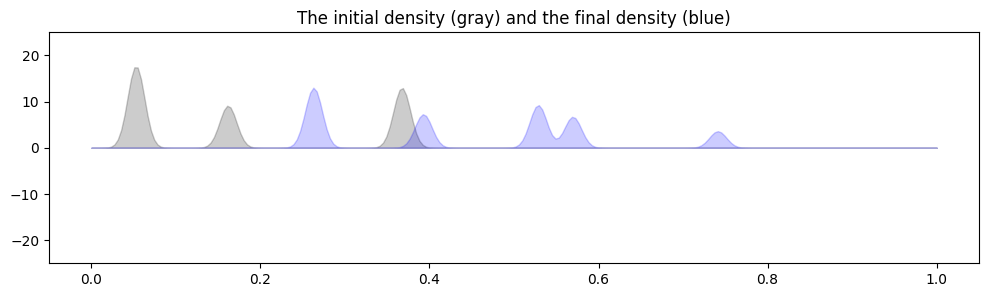

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
WFR: 0.8029211514447138
Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


interactive(children=(IntSlider(value=0, description='t', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

In [6]:
# Define the initial and the terminal distributions
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain
_, rho_0 = generate_gaussian_mixture(3, 1.0, K, sigma=0.01)
_, rho_1 = generate_gaussian_mixture(5, 1.0, K, sigma=0.01)

rho_0 = rho_0 * 256 * 5 # Multiplier to make sure it is an unbalanced problem
rho_1 = rho_1 * 256 * 3

plt.figure(figsize=(12, 3))
plt.ylim(-25, 25)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0/5, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1/3, color="b", alpha=0.2)
plt.show()

T = 60
z, lists = computeGeodesic(rho_0, rho_1, T, (1.0, 1.0))

WFR = np.sqrt(z.V.energy(1.0, 2.0, 2.0))
print(f"WFR: {WFR}")
SHK = WFR_to_SHK(WFR)
r0 = 1.0
r1 = 1.0

# Reparametrize the mass distributions
reparam_D = reparametrize_mass_distributions(z.U.D[0], SHK, r0, r1, (1, K), (1, 1))

# Calculate the constrained geodesic
z, lists = computeGeodesic(rho_0/5, rho_1/3, T, (1.0, 1.0), np.ones((T, K)), np.ones(T))

def plot_1D(t, x, reparam_D, X, ylim=[-2, 2], title=""):
    plt.figure(figsize=[8, 4])  # Adjusted the height for two subplots

    # First subplot for x.U.D
    plt.subplot(2, 1, 1)
    plt.fill_between(X, x.U.D[0][t, :], color="r", alpha=0.7, label=r'$\rho_{t}$')
    plt.title(f'{title} - Constrained UOT')
    plt.axis([0, 1, ylim[0], ylim[1]])
    plt.legend()

    # Second subplot for reparam_D
    plt.subplot(2, 1, 2)
    plt.fill_between(X, reparam_D[t, :], color="g", alpha=0.7, label=r'$\rho_{\beta(t)}$')
    plt.title(f'{title} - Projected unconstrained UOT')
    plt.axis([0, 1, ylim[0], ylim[1]])
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()


interact(lambda t: plot_1D(t, z, reparam_D, X, ylim=[-25, 25], title = 'Comparison'), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

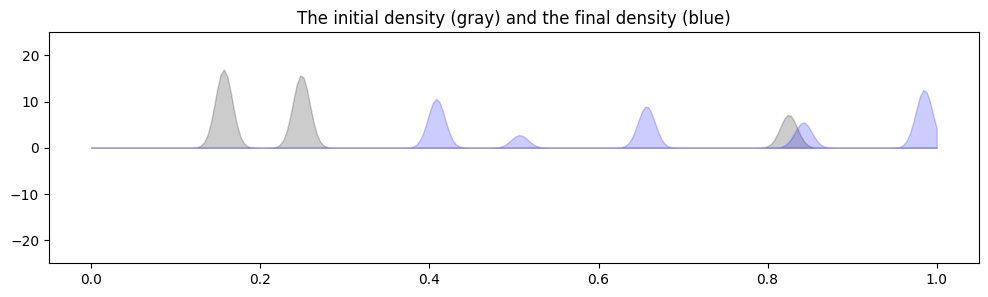

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
WFR: 0.9162633092317625
Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


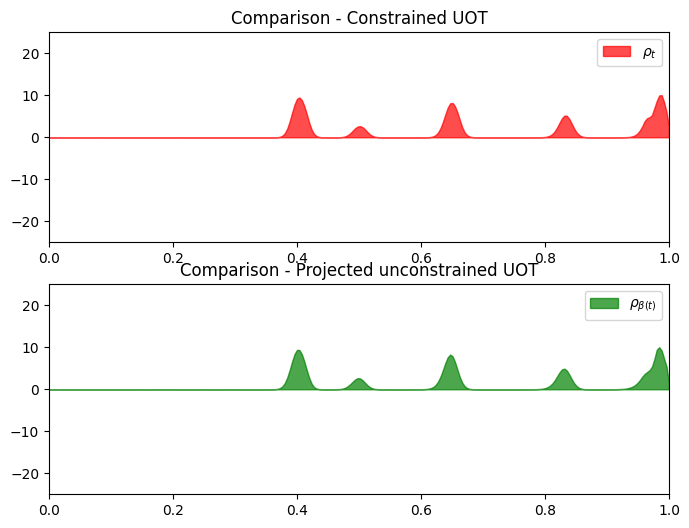

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define the initial and the terminal distributions
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain
_, rho_0 = generate_gaussian_mixture(3, 1.0, K, sigma=0.01)
_, rho_1 = generate_gaussian_mixture(5, 1.0, K, sigma=0.01)

rho_0 = rho_0 * 256 * 5  # Multiplier to make sure it is an unbalanced problem
rho_1 = rho_1 * 256 * 3

plt.figure(figsize=(12, 3))
plt.ylim(-25, 25)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0 / 5, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1 / 3, color="b", alpha=0.2)
plt.show()

T = 60
z, lists = computeGeodesic(rho_0, rho_1, T, (1.0, 1.0))

WFR = np.sqrt(z.V.energy(1.0, 2.0, 2.0))
print(f"WFR: {WFR}")
SHK = WFR_to_SHK(WFR)
r0 = 1.0
r1 = 1.0

# Reparametrize the mass distributions
reparam_D = reparametrize_mass_distributions(z.U.D[0], SHK, r0, r1, (1, K), (1, 1))

# Calculate the constrained geodesic
z, lists = computeGeodesic(rho_0 / 5, rho_1 / 3, T, (1.0, 1.0), np.ones((T, K)), np.ones(T))

# Set up the figure and axes
ylim = [-25, 25]
fig, axs = plt.subplots(2, 1, figsize=[8, 6])

def init():
    # Initialize the plots
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(ylim)
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(ylim)
    return axs

def update(t):
    for ax in axs:
        ax.clear()

    # First subplot for x.U.D
    axs[0].fill_between(X, z.U.D[0][t, :], color="r", alpha=0.7, label=r'$\rho_{t}$')
    axs[0].set_title('Comparison - Constrained UOT')
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(ylim)
    axs[0].legend()

    # Second subplot for reparam_D
    axs[1].fill_between(X, reparam_D[t, :], color="g", alpha=0.7, label=r'$\rho_{\beta(t)}$')
    axs[1].set_title('Comparison - Projected unconstrained UOT')
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(ylim)
    axs[1].legend()

    return axs

ani = animation.FuncAnimation(fig, update, frames=range(T), init_func=init, blit=False)

# Save the animation as an MP4 video
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
ani.save('animation.mp4', writer=writer)

In [39]:
print(np.linalg.norm(reparam_D - z.U.D[0])/(256*60))
print(np.linalg.norm(rho_0-rho_1)/256)
print(z.dist_from_CE())
print(z.dist_from_constraint(np.ones((T, K)), np.ones(T)))

0.007427554252264771
1.1049414275612022
0.2625595584436363
0.0007211623906715111


In [40]:
np.save('rho_0_SHK.npy', rho_0)
np.save('rho_1_SHK.npy', rho_1)